In [1]:
import os   #for interacting with the operating system
import flexynesis   #streamlines data processing, enforces structured data splitting, and ensures rigorous model evaluation. 
import torch  # Importing PyTorch for deep learning and tensor operations
import numpy as np  #for numerical operations, working with arrays and matrices
import seaborn as sns #for statistical data visualization (based on matplotlib)
import pandas as pd   #for data manipulation and analysis using DataFrames
import random   # Importing random module to generate random numbers and shuffle data
import lightning as pl  # Importing lightning (lightning.ai) for building and scaling deep learning workflows

Seed set to 42


Here, we demonstrate the capabilities of flexynesis on a multi-omic dataset of 506 Brain Lower Grade Glioma (LGG) and 288 Glioblastoma Multiforme (GBM) samples with matching mutation and copy number alteration data downloaded from the cbio portal https://www.cbioportal.org/study/summary?id=lgggbm_tcga_pub. The data was split into train (70% of the samples) and test (30% of the samples) data folders. The data files were processed to follow the same nomenclature.

-cna.csv contains "copy number alteration" data -mut.csv contains "mutation" data, which is a binary matrix of genes versus samples. -clin.csv contains "clinical/sample metatada", which is a table of clinical parameters such as age, sex, disease type, histological diagnosis, and overall survival time and status.

In [2]:
# Download dataset 
if not os.path.exists("lgggbm_tcga_pub_processed"):
    !wget -O lgggbm_tcga_pub_processed.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz" && tar -xzvf lgggbm_tcga_pub_processed.tgz

--2025-03-13 17:33:11--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.47, 141.80.181.46
connected. to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1817945 (1.7M) [application/octet-stream]
Saving to: ‘lgggbm_tcga_pub_processed.tgz’

lgggbm_tcga_pub_pro 100%[===================>]   1.73M  --.-KB/s    in 0.1s    

2025-03-13 17:33:11 (15.9 MB/s) - ‘lgggbm_tcga_pub_processed.tgz’ saved [1817945/1817945]

lgggbm_tcga_pub_processed/
lgggbm_tcga_pub_processed/train/
lgggbm_tcga_pub_processed/train/mut.csv
lgggbm_tcga_pub_processed/train/cna.csv
lgggbm_tcga_pub_processed/train/clin.csv
lgggbm_tcga_pub_processed/test/
lgggbm_tcga_pub_processed/test/mut.csv
lgggbm_tcga_pub_processed/test/cna.csv
lgggbm_tcga_pub_processed/test/clin.csv


In [3]:
print(pd.read_csv("lgggbm_tcga_pub_processed/train/clin.csv", index_col=0).head())

                                 STUDY BCR_STATUS HISTOLOGICAL_DIAGNOSIS  \
TCGA-06-0645   Glioblastoma multiforme        IGC           glioblastoma   
TCGA-HT-A74J  Brain Lower Grade Glioma        IGC       oligoastrocytoma   
TCGA-E1-5303  Brain Lower Grade Glioma        IGC            astrocytoma   
TCGA-DU-5854  Brain Lower Grade Glioma        IGC            astrocytoma   
TCGA-HT-7472  Brain Lower Grade Glioma        IGC      oligodendroglioma   

               AGE     SEX  OS_MONTHS  OS_STATUS  KARNOFSKY_PERFORMANCE_SCORE  
TCGA-06-0645  55.0  Female        5.7        1.0                          NaN  
TCGA-HT-A74J  33.0    Male       10.5        0.0                          NaN  
TCGA-E1-5303  38.0    Male       67.4        1.0                         80.0  
TCGA-DU-5854  57.0  Female        8.4        0.0                         90.0  
TCGA-HT-7472  38.0    Male        0.0        0.0                          NaN  


In [4]:
print(pd.read_csv("lgggbm_tcga_pub_processed/train/cna.csv").head())

         TCGA-06-0645  TCGA-HT-A74J  TCGA-E1-5303  TCGA-DU-5854  TCGA-HT-7472  \
ACAP3           0.131         0.009        -0.001        -0.004           0.0   
ACTRT2          0.131         0.009        -0.001        -0.004           0.0   
AGRN            0.131         0.009        -0.001        -0.004           0.0   
ANKRD65         0.131         0.009        -0.001        -0.004           0.0   
ATAD3A          0.131         0.009        -0.001        -0.004           0.0   

         TCGA-DU-A7TA  TCGA-12-5299  TCGA-DB-A75K  TCGA-DU-A5TP  TCGA-HT-8564  \
ACAP3          -0.078           0.0        -0.804        -0.008         0.014   
ACTRT2         -0.078           0.0        -0.804        -0.008         0.014   
AGRN           -0.078           0.0        -0.804        -0.008         0.014   
ANKRD65        -0.078           0.0        -0.804        -0.008         0.014   
ATAD3A         -0.078           0.0        -0.804        -0.008         0.014   

         ...  TCGA-TQ-A7RI

In [5]:
print(pd.read_csv("lgggbm_tcga_pub_processed/train/mut.csv").head())

        TCGA-06-0645  TCGA-HT-A74J  TCGA-E1-5303  TCGA-DU-5854  TCGA-HT-7472  \
A1BG               0             0             0             0             0   
A1CF               0             0             0             0             0   
A2M                0             0             0             0             0   
A2ML1              0             0             0             1             0   
A4GALT             0             0             0             0             0   

        TCGA-DU-A7TA  TCGA-12-5299  TCGA-DB-A75K  TCGA-DU-A5TP  TCGA-HT-8564  \
A1BG               0             0             0             0             0   
A1CF               0             0             0             0             0   
A2M                0             0             0             0             0   
A2ML1              0             0             0             0             0   
A4GALT             0             0             0             0             0   

        ...  TCGA-TQ-A7RI  TCGA-HW-832

Importing Train and Test Datasets We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 10% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8 and a variance threshold of 50%. By setting concatenate to False, we will be doing an intermediate fusion of omic layers.

In [78]:
data_importer = flexynesis.DataImporter(path ='lgggbm_tcga_pub_processed', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000, correlation_threshold=0.8, 
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/train/mut.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/test/mut.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5561 features.

[INFO] working on layer:  cna
[INFO] Number of

Filtering redundant features: 100%|██████████| 1000/1000 [00:00<00:00, 14787.00it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  12371 features  and  556  samples 


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec


[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5627 features.

[INFO] working on layer:  cna
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 12382 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: cna': 1237, 'feature_count in: mut': 313, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: cna': 1237, 'feature_count in: mut': 313, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


### 1. Exploratory Data Analysis
Before building any machine learning models on the data, it is important to first familiarize yourself with the data you are working with. It is important to know the available data matrices, their sizes/shapes, available clinical variables and how they are distributed.

Below you are asked to do simple explorations of the available data.

#### 1.1 Print the shapes of the available data matrices
How many features and samples are available per data type in train/test datasets?

In [47]:
print(f"Train datasets are as follows: Copy number alteration data: {pd.read_csv('lgggbm_tcga_pub_processed/train/cna.csv').shape}, Mutation data: {pd.read_csv('lgggbm_tcga_pub_processed/train/mut.csv').shape}, Clinical/sample metadata: {pd.read_csv('lgggbm_tcga_pub_processed/train/clin.csv').shape}")

Train datasets are as follows: Copy number alteration data: (24746, 556), Mutation data: (11064, 556), Clinical/sample metadata: (556, 8)


In [48]:
print(f"Test datasets are as follows: Copy number alteration data: {pd.read_csv('lgggbm_tcga_pub_processed/test/cna.csv').shape}, Mutation data: {pd.read_csv('lgggbm_tcga_pub_processed/test/mut.csv').shape}, Clinical/sample metadata: {pd.read_csv('lgggbm_tcga_pub_processed/test/clin.csv').shape}")

Test datasets are as follows: Copy number alteration data: (24746, 238), Mutation data: (11064, 238), Clinical/sample metadata: (238, 8)


#### 1.2 Explore sample annotations
What are the available clinical variables? Are they available in both train and test datasets? (See .ann)

In [49]:
#dataset.ann contains the sample annotation data (from clin.csv), where the keys are variable names and values are tensors.
train_dataset.ann

{'AGE': tensor([58., 74., 43., nan, 47., 35., 81., 60., 64., 63., 67., 76., 44., 23.,
         67., 59., 60., 56., 48., 33., 59., 25., 53., 37., 21., 47., 58., 33.,
         nan, 34., 47., 40., 72., 46., 43., 67., 30., 57., 51., 60., 39., 44.,
         49., 40., 31., 56., nan, 77., 65., 74., 30., 65., 72., 32., 35., 63.,
         30., 53., 32., nan, 45., nan, 53., 46., 29., nan, 43., nan, 27., 65.,
         25., 31., 39., 48., 73., 59., 29., 21., 75., 40., 25., nan, 81., 38.,
         30., 29., 45., 69., 33., nan, 57., 60., 76., 29., 33., 56., 28., 74.,
         73., 47., 53., 49., 71., 61., 32., 61., 53., 43., 41., 72., 55., 38.,
         74., 37., 36., 66., 55., 56., nan, 85., 45., 38., 52., 39., 74., 50.,
         nan, 37., 85., 66., 30., 31., nan, 52., 49., 40., 40., 47., 33., 66.,
         61., 27., 75., 41., 52., 68., 74., 62., 74., 33., 40., 58., 57., 17.,
         72., 67., 60., 33., 64., 65., 81., 52., 79., 38., 37., 49., 50., 70.,
         63., 21., 39., 78., 66., 76., 71., 3

In [50]:
test_dataset.ann

{'AGE': tensor([37., nan, 39., 34., 57., 33., 41., nan, 74., 32., 59., 33., 62., 73.,
         23., 53., 38., 62., 25., 65., 32., 74., 54., nan, 34., 44., 78., 35.,
         50., 48., 63., nan, 50., 44., 42., 31., 31., 59., 41., 38., 29., 61.,
         55., 56., nan, 38., 66., 53., 64., 54., 49., 52., 62., 66., 39., 83.,
         54., nan, nan, 37., nan, 61., 59., 33., 43., 32., 73., 31., 57., 61.,
         30., 48., 52., 24., 38., nan, 24., 53., 78., 30., 35., 39., 86., 58.,
         43., 30., 44., 63., 60., 58., 41., 60., 59., 73., 20., 30., 62., 40.,
         52., 62., 70., 63., 47., 30., 20., 41., 53., 65., 24., 36., 89., 55.,
         55., 73., nan, 66., 57., 49., 56., 65., 60., 66., 35., 38., 62., 72.,
         58., 33., 31., 31., 68., 34., 73., 38., 39., 72., 52., 36., 59., 56.,
         34., 41., 28., 87., nan, nan, 71., 41., nan, 36., nan, 48., 50., 44.,
         61., 58., nan, 43., 64., nan, nan, 75., 54., 52., 54., 59., 55., 50.,
         37., 39., 52., 40., nan, 33., 45., 3

- Make a histogram plot of the follow up times in months (OS_MONTHS) (use sns.histplot)

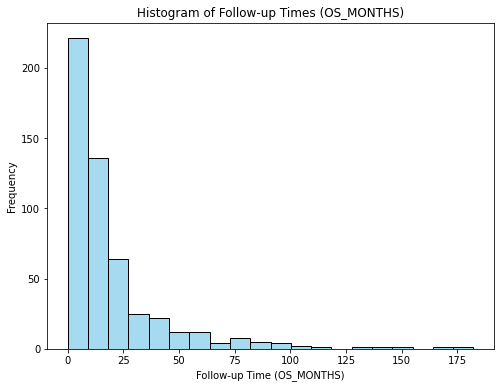

In [51]:
# The 'OS_MONTHS' tensor from train_dataset.ann
#Since the values are stored as a tensor in train_dataset.ann['OS_MONTHS'], 
#we'll need to convert them to a pandas-compatible format (such as a numpy array or pandas Series) before plotting.

import matplotlib.pyplot as plt

os_months = train_dataset.ann['OS_MONTHS'].cpu().numpy()  # Convert tensor to numpy array
os_months = os_months[~np.isnan(os_months)] # Remove NaN values
sns.histplot(os_months, kde=False, bins=20, color="skyblue")  # Create the histogram plot using seaborn

# Add labels and title
plt.xlabel('Follow-up Time (OS_MONTHS)')
plt.ylabel('Frequency')
plt.title('Histogram of Follow-up Times (OS_MONTHS)')

# Show the plot
plt.show()

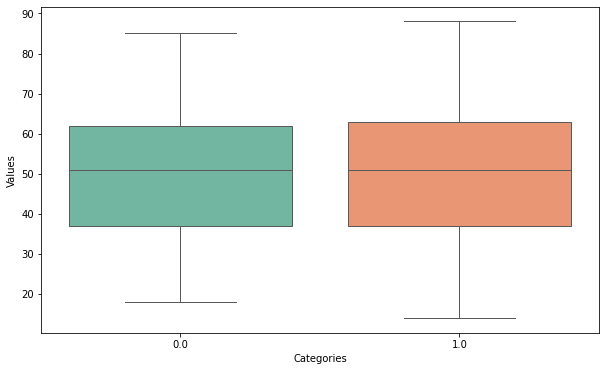

In [52]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

flexynesis.utils.plot_boxplot(
    train_dataset.ann['SEX'],  # Categorical variable
    train_dataset.ann['AGE']   # Numerical variable
)

- Make a summary of all available clinical variables (see flexynesis.print_summary_stats)

In [53]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: AGE
Numerical Variable Summary: Median = 51.0, Mean = 50.33781190019194
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 11.6, Mean = 19.090978886756236
------
Summary for variable: OS_STATUS
Numerical Variable Summary: Median = 0.0, Mean = 0.36153846153846153
------
Summary for variable: KARNOFSKY_PERFORMANCE_SCORE
Numerical Variable Summary: Median = 80.0, Mean = 82.45454545454545
------
Summary for variable: STUDY
Categorical Variable Summary:
  Label: Brain Lower Grade Glioma, Count: 353
  Label: Glioblastoma multiforme, Count: 203
------
Summary for variable: BCR_STATUS
Categorical Variable Summary:
  Label: IGC, Count: 454
  Label: NCH, Count: 102
------
Summary for variable: HISTOLOGICAL_DIAGNOSIS
Categorical Variable Summary:
  Label: astrocytoma, Count: 115
  Label: glioblastoma, Count: 201
  Label: oligoastrocytoma, Count: 79
  Label: oligodendroglioma, Count: 126
  Label: nan, Count: 35
------
Summary for variable: SEX
Categor

- Notice that the categorical variables such as "SEX", "STUDY", "HISTOLOGICAL_DIAGNOSIS" are encoded numerically in the "dataset.ann" objects. Use dataset.label_mappings to map the STUDY variable to their original labels. Print the top 10 values in dataset.ann['STUDY'] and the mapped label values

In [54]:
#A mapping of the sample labels for categorical variables can be found in dataset.label_mappings
train_dataset.label_mappings

{'STUDY': {0: 'Brain Lower Grade Glioma', 1: 'Glioblastoma multiforme'},
 'BCR_STATUS': {0: 'IGC', 1: 'NCH'},
 'HISTOLOGICAL_DIAGNOSIS': {0: 'astrocytoma',
  1: 'glioblastoma',
  2: 'oligoastrocytoma',
  3: 'oligodendroglioma',
  4: nan},
 'SEX': {0: 'Female', 1: 'Male', 2: nan}}

In [55]:
print(train_dataset.ann['STUDY'][:10])

tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0.], dtype=torch.float64)


- Now, let's explore the data matrices. Make a PCA plot of the mutation data matrix and color the samples by "HISTOLOGICAL_DIAGNOSIS". See flexynesis.plot_dim_reduced function

First create a pandas data frame with the data matrix of interest with feature and sample names
df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

Check the data frame contents
df.head()

Make a PCA plot of CNA values using the labels from the STUDY variable

Note: if you couldn't map the labels above, you can also use train_dataset.dat['STUDY'] as labels

In [56]:
# Create a DataFrame for CNA data matrix
df = pd.DataFrame(train_dataset.dat['cna'], index=train_dataset.samples, columns=train_dataset.features['cna'])

# Check the first few rows of the dataframe
df.head()

,SLC30A8,ZNF273,OR9A1P,AGL,KCNA5,MIR603,SNTB1,MRPL13,MTBP,SNORA72|ENSG00000252158.1,...,CAV1,FZD1,BCAP29,MNX1,ADAM22,LRP8,NOM1,RN7SL290P,CEP41,snoU13|ENSG00000239044.1
TCGA-S9-A6WD,-0.262026,-0.747855,-0.873834,-1.397916,-0.185801,0.584616,-0.271057,-0.270898,-0.270898,-0.233569,...,-0.875647,-0.821836,-0.876168,-0.854416,-0.797862,-1.346543,-0.854597,-1.354614,-0.895180,-0.895180
TCGA-14-0871,0.803414,1.973204,1.884189,2.942561,-0.499669,-1.218370,0.811422,0.811559,0.811559,0.803367,...,1.880812,1.879839,1.903375,1.873636,1.760577,2.959935,1.873364,2.995690,1.817840,1.817840
TCGA-DH-A66D,-0.254134,-0.722640,0.077990,0.383907,-0.470410,0.665347,-0.263039,-0.262880,-0.262880,-0.265474,...,0.074153,-0.795174,0.081586,0.087064,-0.772615,0.400502,0.086852,0.410210,0.041113,0.041113
TCGA-RY-A847,-0.259395,-0.743652,-0.867035,-1.924858,-0.191121,0.573404,-0.268384,-0.268225,-0.268225,-0.270792,...,-0.871113,-0.817392,-0.871596,-0.847691,-0.793655,-1.908966,-0.847873,-1.922761,-0.888492,-0.888492
TCGA-HT-A614,1.845179,-0.712134,-0.771853,0.405636,5.527668,0.568919,1.869845,1.869962,1.869962,1.856255,...,-0.775906,-0.724078,-0.775592,-0.753543,-0.705287,0.422238,-0.753728,0.432167,-0.794863,-0.794863


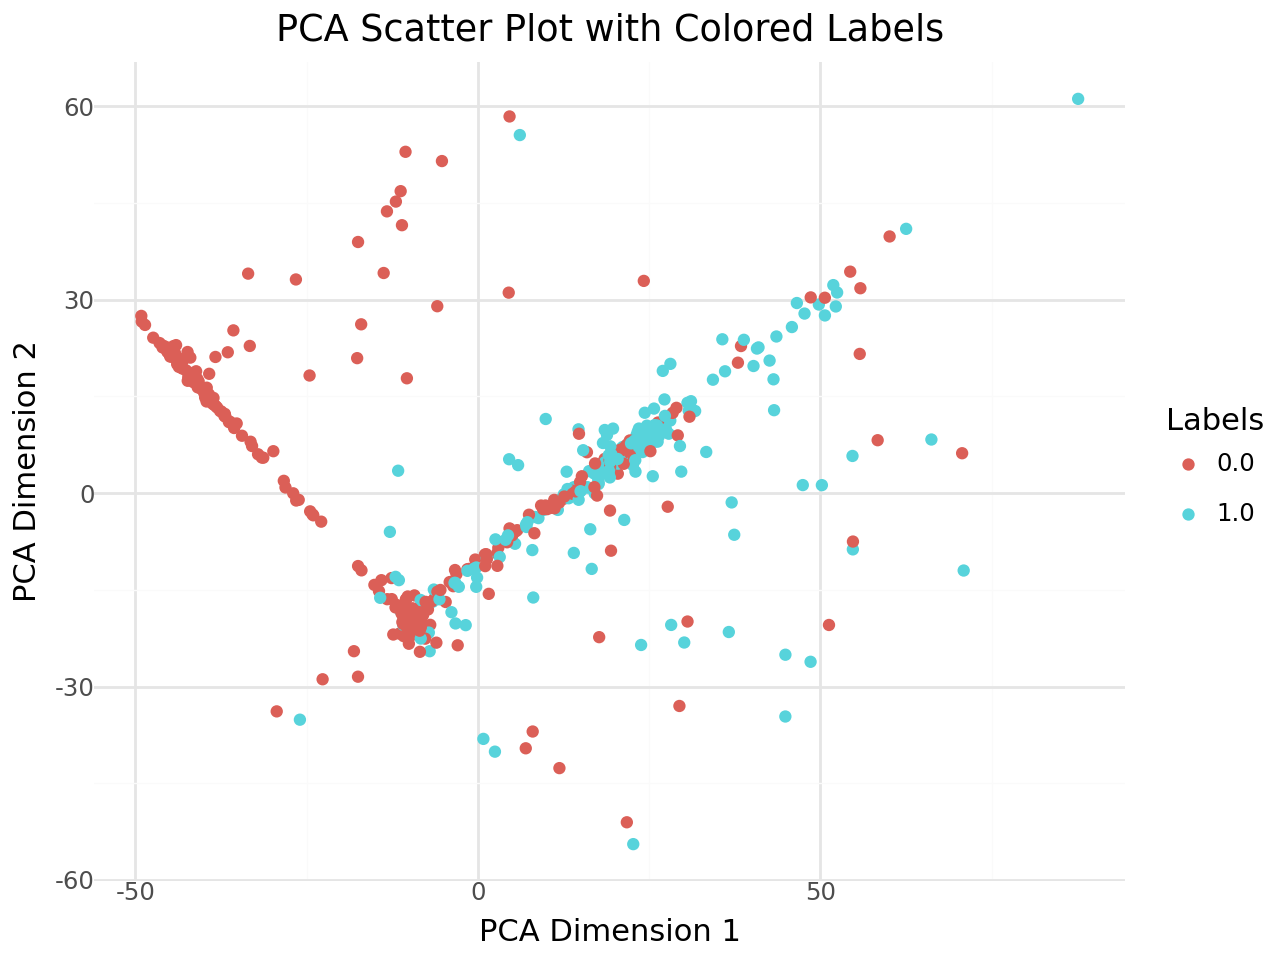

In [57]:
# Use 'STUDY' for color labels
labels = train_dataset.ann['STUDY'] 

# Plot the PCA
flexynesis.plot_dim_reduced(df, labels=labels)

- (Optional exercise ideas):
- - Make a PCA plot coloring the samples by HISTOLOGICAL_DIAGNOSIS, GENDER, or any other clinical variable
- - Repeat the same exercise on the mutation data matrix.

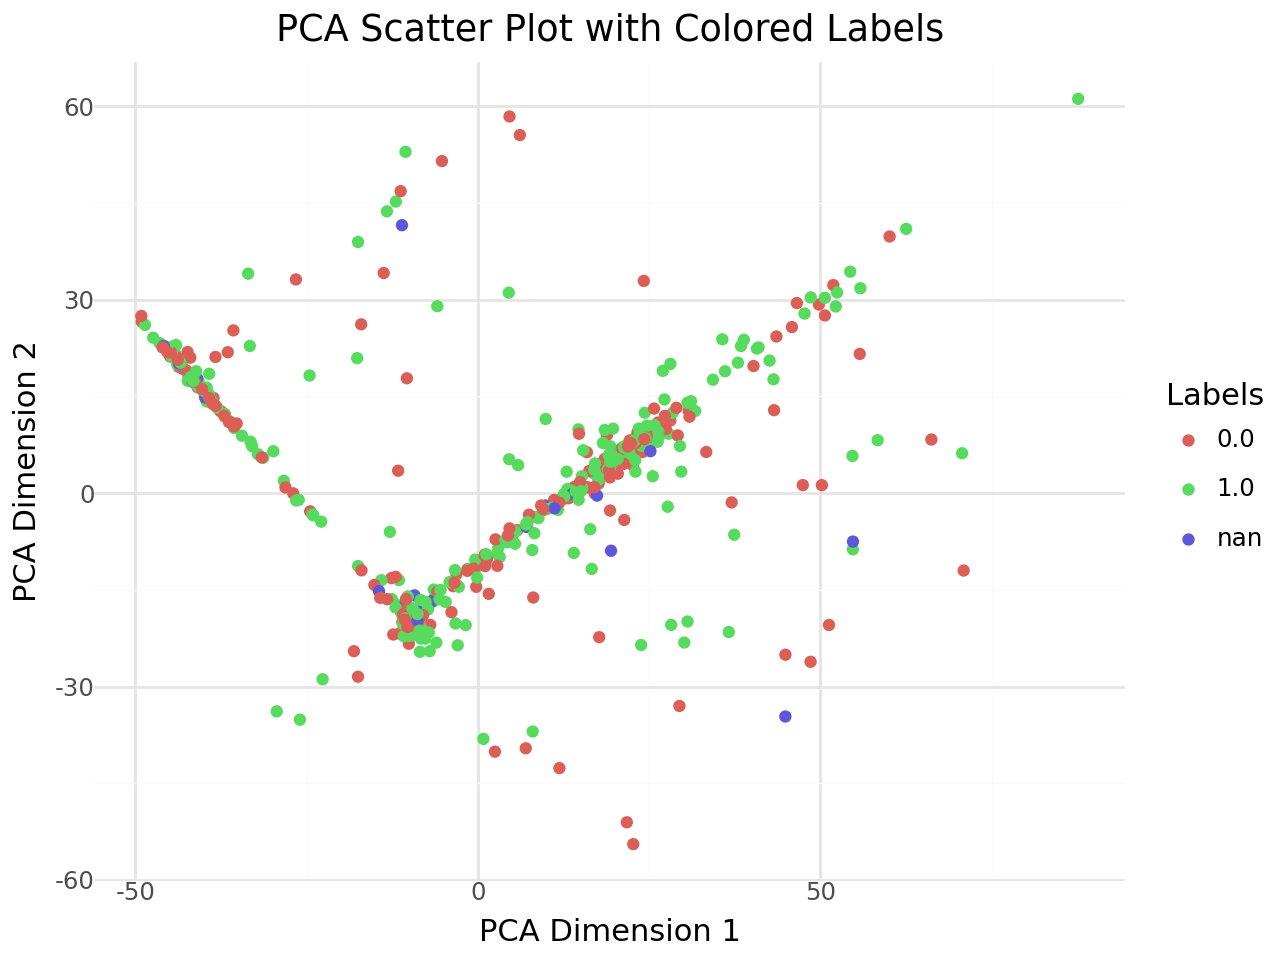

In [58]:
# Use 'STUDY' for color labels
labels = train_dataset.ann['SEX'] 

# Plot the PCA
flexynesis.plot_dim_reduced(df, labels=labels)

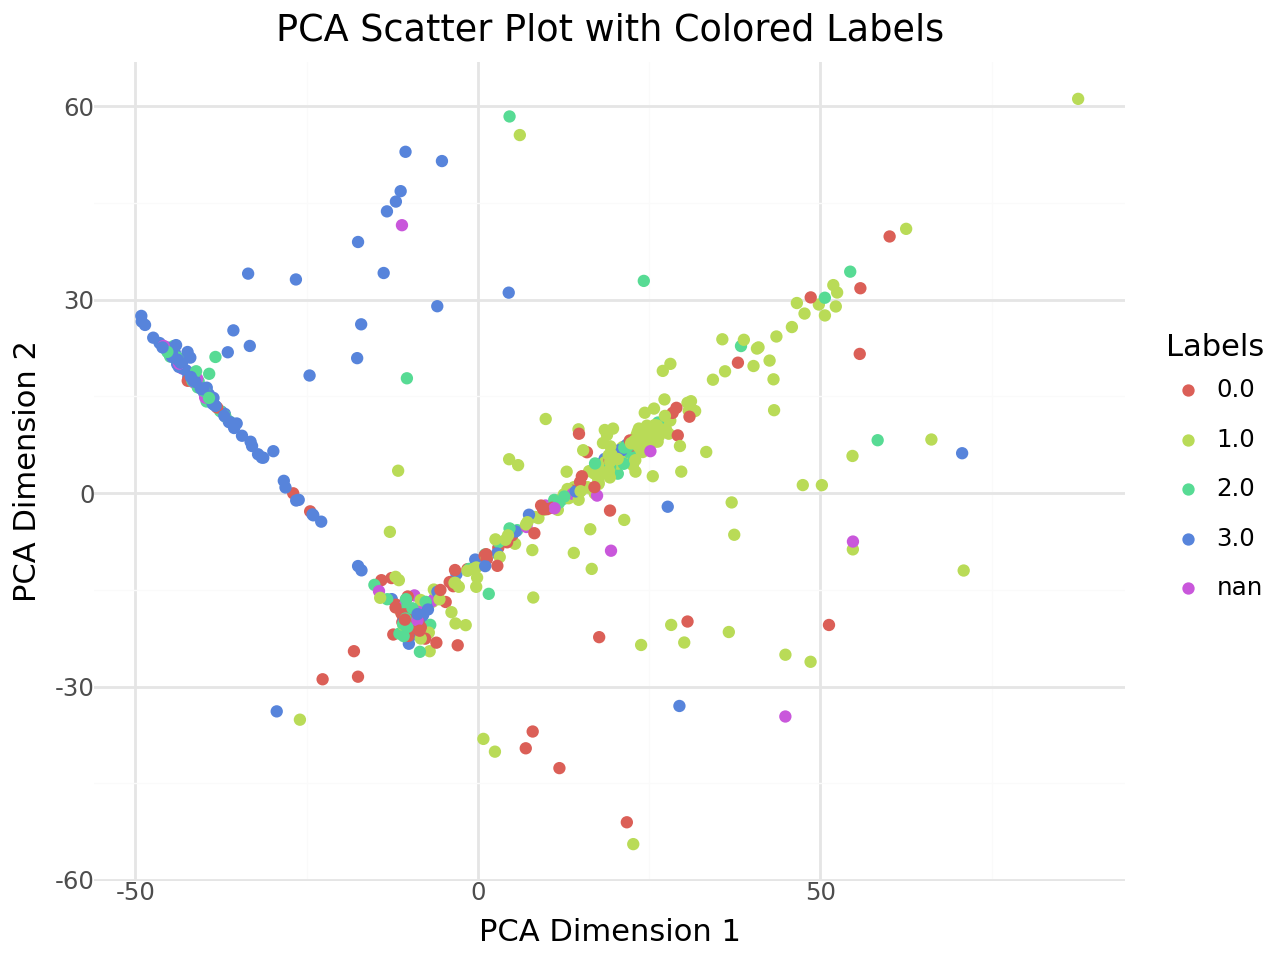

In [59]:
# Use 'STUDY' for color labels
labels = train_dataset.ann['HISTOLOGICAL_DIAGNOSIS'] 

# Plot the PCA
flexynesis.plot_dim_reduced(df, labels=labels)

In [60]:
# Create a DataFrame for Mutation data matrix
df_mut = pd.DataFrame(train_dataset.dat['mut'], index=train_dataset.samples, columns=train_dataset.features['mut'])

# Check the first few rows of the dataframe
df_mut.head()

,IDH1,IDH2,ATRX,RELN,PIK3CA,EGFR,TP53,COL6A3,SVIL,CIC,...,PPM1H,SIGLEC12,PTPN6,CAMKK1,SEPT12,NAGA,NEURL1,ZNF571,NYAP2,LAS1L
TCGA-S9-A6WD,0.982173,-0.148522,-0.585658,-0.172133,-0.307389,-0.331331,-0.809174,-0.177595,-0.104447,-0.344546,...,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.060084
TCGA-14-0871,-1.018150,-0.148522,-0.585658,-0.172133,-0.307389,-0.331331,1.235829,-0.177595,-0.104447,-0.344546,...,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.060084
TCGA-DH-A66D,0.982173,-0.148522,1.707482,-0.172133,-0.307389,-0.331331,1.235829,-0.177595,-0.104447,-0.344546,...,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.060084
TCGA-RY-A847,0.982173,-0.148522,-0.585658,5.809475,-0.307389,-0.331331,-0.809174,-0.177595,-0.104447,-0.344546,...,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.060084
TCGA-HT-A614,0.982173,-0.148522,1.707482,-0.172133,-0.307389,-0.331331,1.235829,-0.177595,-0.104447,-0.344546,...,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.042448,-0.060084


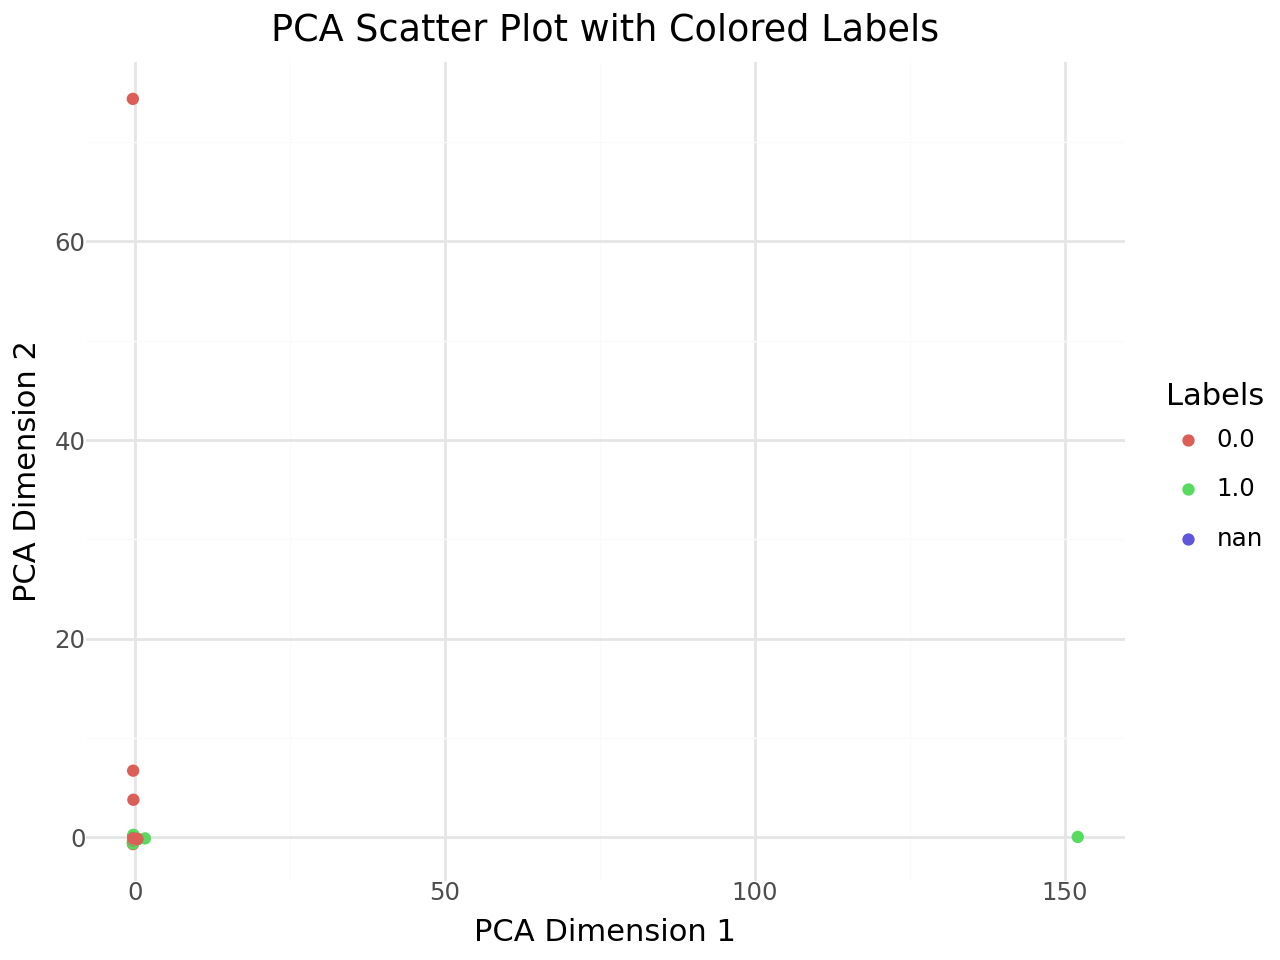

In [61]:
# Use 'STUDY' for color labels
labels = train_dataset.ann['SEX'] 

# Plot the PCA
flexynesis.plot_dim_reduced(df_mut, labels=labels)

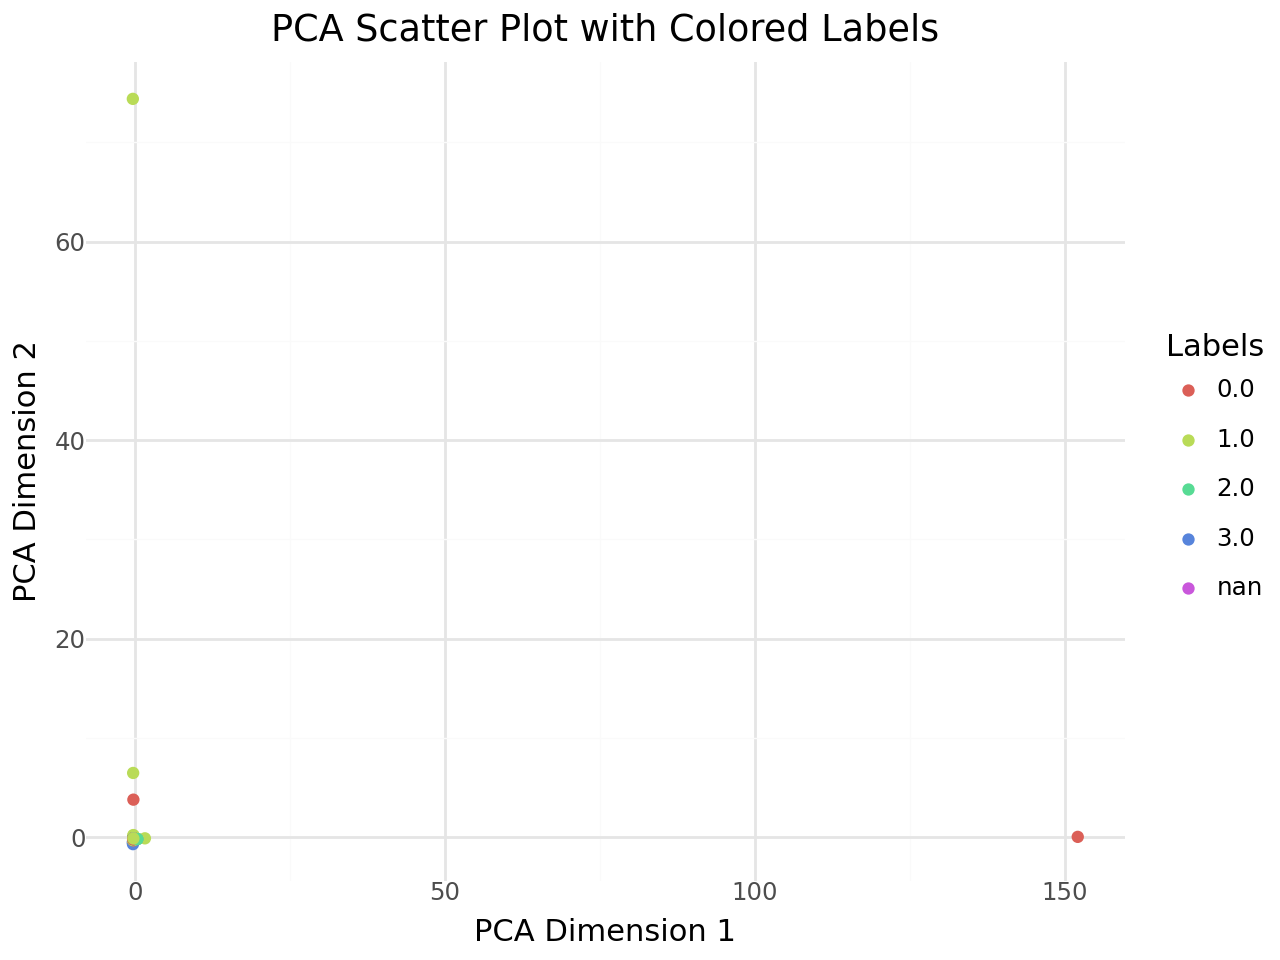

In [62]:
# Plot the PCA
labels = train_dataset.ann['HISTOLOGICAL_DIAGNOSIS'] 

# Plot the PCA
flexynesis.plot_dim_reduced(df_mut, labels=labels)

## 2. Training a single model using manually set hyperparameters
Now that we have familiarized ourselves with the dataset at hand, we can start building models.
First we will do a single model training by manually setting hyperparameters. Based on the model performance, we will try modifying individual hyperparameters and build more and more models and see if we can improve model performance.

We will need to define the following components for starting a model training:

1. Split the train_dataset into train/validation components 
2. Define data loaders for both train and validation splits 
3. Define a pytorch-lightning trainer 
4. Define a model with hyperparameters 
5. Fit the model 

In [63]:
# randomly assign 80% of samples for training, 20% for validation 
train_indices = random.sample(range(0, len(train_dataset)), int(len(train_dataset) * 0.8))
val_indices = list(set(range(len(train_dataset))) - set(train_indices))
train_subset = train_dataset.subset(train_indices)
val_subset = train_dataset.subset(val_indices)

# define data loaders for train/validation splits 
from torch.utils.data import DataLoader
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_subset, batch_size=32, shuffle = False) 

Now, we need to define a model with manually set hyperparameters and a lightning-trainer fit the model.

Notice: Notice the callback we are passing to the trainer which enables us to plot the loss values as the training progresses.

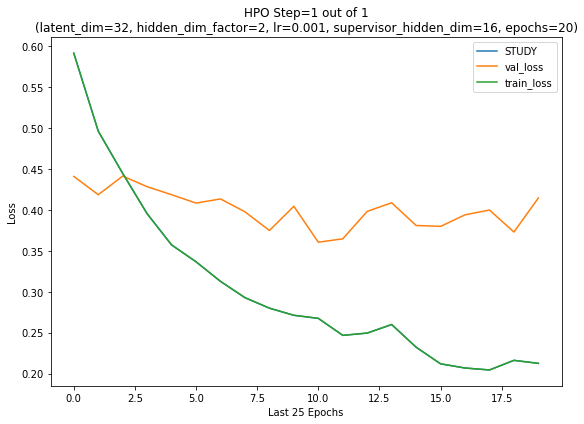

`Trainer.fit` stopped: `max_epochs=20` reached.


In [64]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 32, 'hidden_dim_factor': 2, 'lr': 0.001, 'supervisor_hidden_dim': 16, 'epochs': 20}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)

While we can observe how well the model training went based on the "loss" values, we can also evaluate the model performance on test dataset

In [65]:
# evaluate the model performance on predicting the target variable
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.752288
1,DirectPred,STUDY,categorical,f1_score,0.782020
2,DirectPred,STUDY,categorical,kappa,0.519515
3,DirectPred,STUDY,categorical,average_auroc,0.835755
4,DirectPred,STUDY,categorical,average_aupr,0.690963


2.1 Exercise
Now, repeat the above model training and evaluation by manually changing the hyperparameters (Try at least 5 different combinations)
See if you can find a better hyperparameter combination that yields a better classification performance than the initial setup we provided.
See the default hyperparameter ranges we use for Flexynesis here: https://github.com/BIMSBbioinfo/flexynesis/blob/69b92ca9370551e9fcc82a756cb42c72bef4a4b1/flexynesis/config.py#L7, but feel free to try outside these ranges too.
Also try to observe the impact of the changing parameters on how the train/validation loss curves change.
myparams = {'latent_dim': XX, 'hidden_dim_factor': XX, 'lr': XX, 'supervisor_hidden_dim': XX, 'epochs': XX}

model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   

trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

trainer.fit(model, train_loader, val_loader)

flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

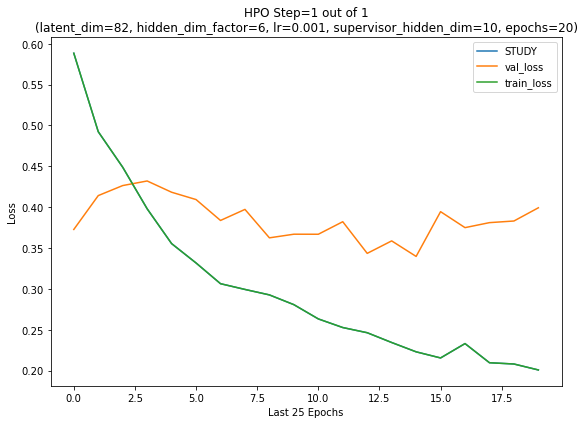

`Trainer.fit` stopped: `max_epochs=20` reached.


In [66]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 82, 'hidden_dim_factor': 6, 'lr': 0.001, 'supervisor_hidden_dim': 10, 'epochs': 20}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)

In [67]:
# evaluate the model performance on predicting the target variable
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.767974
1,DirectPred,STUDY,categorical,f1_score,0.772320
2,DirectPred,STUDY,categorical,kappa,0.515723
3,DirectPred,STUDY,categorical,average_auroc,0.847905
4,DirectPred,STUDY,categorical,average_aupr,0.681459


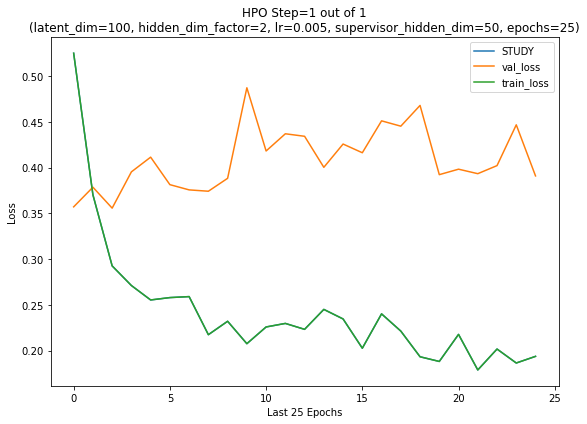

`Trainer.fit` stopped: `max_epochs=25` reached.


In [68]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 100, 'hidden_dim_factor': 2, 'lr': 0.005, 'supervisor_hidden_dim': 50, 'epochs': 25}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)

In [69]:
# evaluate the model performance on predicting the target variable
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.754902
1,DirectPred,STUDY,categorical,f1_score,0.770290
2,DirectPred,STUDY,categorical,kappa,0.503226
3,DirectPred,STUDY,categorical,average_auroc,0.812303
4,DirectPred,STUDY,categorical,average_aupr,0.677995


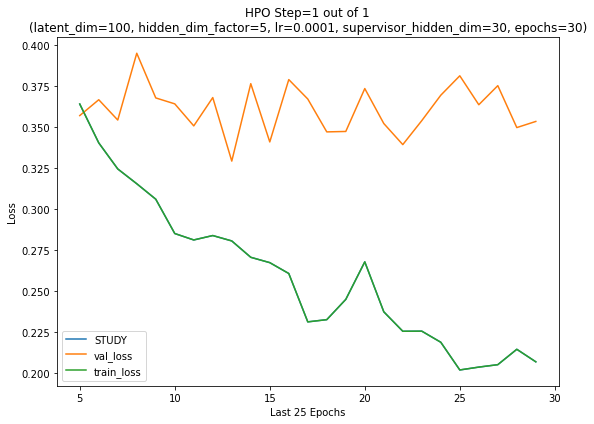

`Trainer.fit` stopped: `max_epochs=30` reached.


In [70]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 100, 'hidden_dim_factor': 5, 'lr': 0.0001, 'supervisor_hidden_dim': 30, 'epochs': 30}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)

In [71]:
# evaluate the model performance on predicting the target variable
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.764706
1,DirectPred,STUDY,categorical,f1_score,0.794466
2,DirectPred,STUDY,categorical,kappa,0.546559
3,DirectPred,STUDY,categorical,average_auroc,0.875509
4,DirectPred,STUDY,categorical,average_aupr,0.760623


*_Warning!!:_* In reality, we don't select the best models based on performance on the test dataset.
The best model is selected based on the validation loss value, where the model parameters that yields the lowest validation loss is selected to be the best model.
The validation dataset which we use to compute the validation loss is basically a subset of the training dataset.

### 3. Automating the Hyperparameter Optimisation Procedure
What we did in the above section was to set random hyperparameters, build a model, evaluate the model and try different hyperparameters based on our previous model performance. However, this process can be quite time consuming and arbitrary. This process can be automated using a Bayesian approach, where the model training is sequentially done for a number of hyperparameter optimisation iterations.

 - Now, we are ready to do a model training using hyperparameter optimisation.

model_class: We pick DirectPred (a fully connected network) for now.
config_name: We use the default/built-in hyperparameter search space for DirectPred class.
target_variables: 'STUDY' variable contains the type of disease
n_iter: We do 5 iterations of hyperparameter optimisation. For demonstration purposes, we set it to a small number.
plot_losses: We want to visualize how the training progresses.
early_stop_patience: If a training does not show any signs of improving the performance on the validation part of the train_dataset for at least 10 epochs, we stop the training. This not only significantly decreases the amount spent on training by avoiding unnecessary continuation of unpromising training runs, but also helps avoid over-fitting the network on the training data.
Note 1: Notice how the hyperparameters using in different HPO steps change at each iteration.

Note 2: Also notice that we are running the model for more epochs (500 by default) however, by using "early_stop_patience=10", we avoid lengthy training when validation performance is not improving.

Note 3: Try to follow the the loss curves and the used hyperparameters. See if you can spot which combination yields the lowest/best loss values.

Warning!!: In reality we need to set n_iter to higher values so that the optimizer can collect enough data points to learn trends in the parameter space.

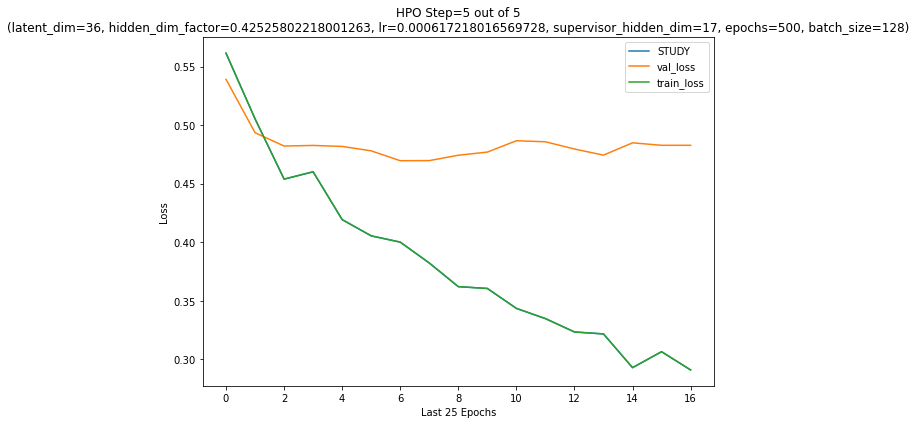

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           STUDY           │    0.4827805459499359     │
│         val_loss          │    0.4827805459499359     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it, Iteration=5, Best Loss=0.417]

[INFO] current best val loss: 0.4165545701980591; best params: {'latent_dim': 76, 'hidden_dim_factor': 0.3435878564467032, 'lr': 0.00019978588012895204, 'supervisor_hidden_dim': 21, 'epochs': 500, 'batch_size': 128} since 2 hpo iterations


In [72]:
# Define a tuner; See n_iter is the number of 
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        target_variables = ['STUDY'], 
                                        n_iter=5, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model, best_params = tuner.perform_tuning()

In [73]:
## See which hyperparameter combination was the best 
best_params

{'latent_dim': 76,
 'hidden_dim_factor': 0.3435878564467032,
 'lr': 0.00019978588012895204,
 'supervisor_hidden_dim': 21,
 'epochs': 68,
 'batch_size': 128}

In [74]:
## Evaluate the model and visualising the results
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.801307
1,DirectPred,STUDY,categorical,f1_score,0.815593
2,DirectPred,STUDY,categorical,kappa,0.599480
3,DirectPred,STUDY,categorical,average_auroc,0.889273
4,DirectPred,STUDY,categorical,average_aupr,0.830010


Let's extract the sample embeddings and make a PCA plot and color by the target variable

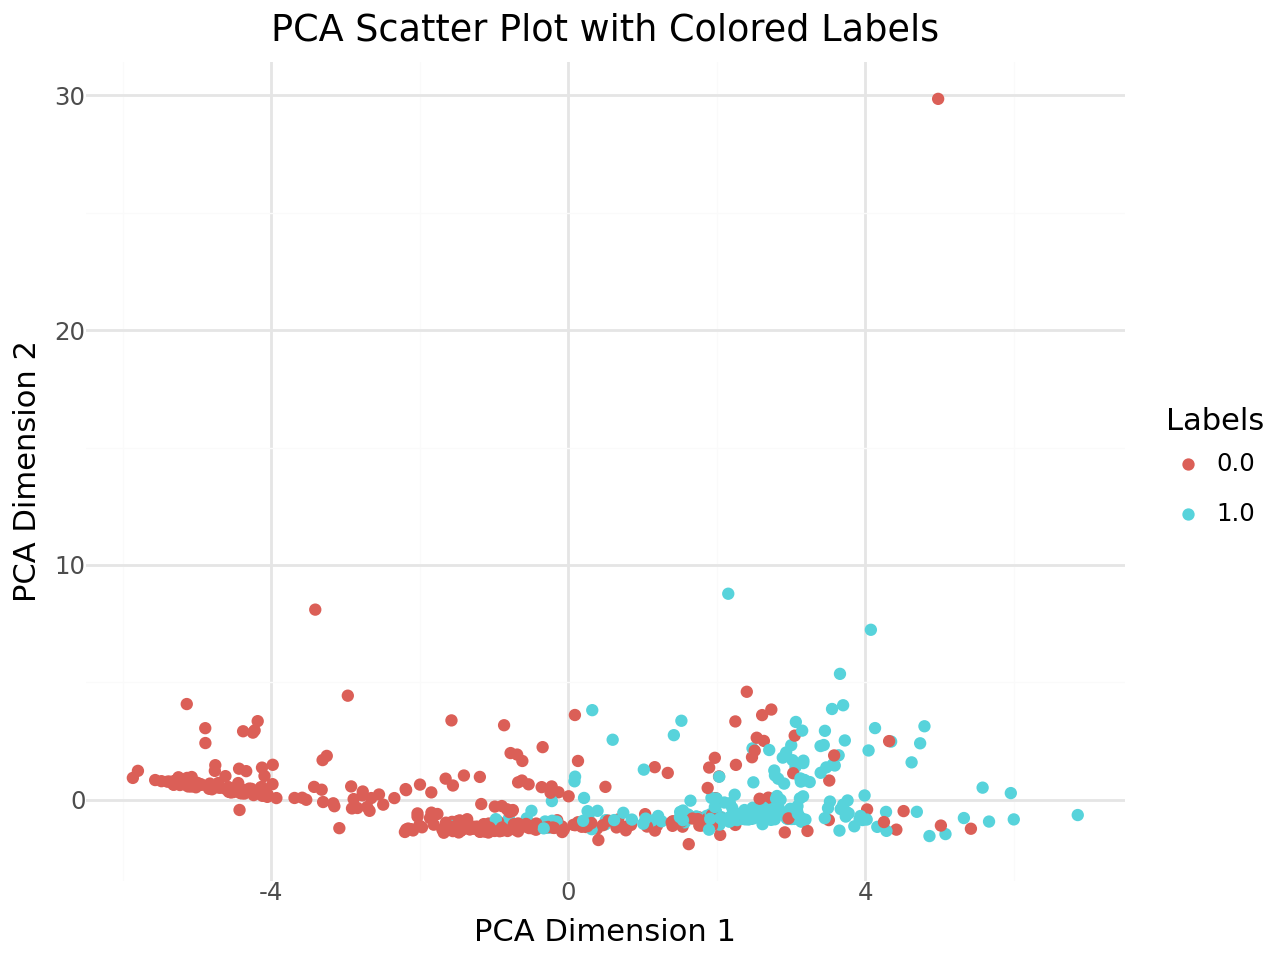

In [75]:
train_embeddings = model.transform(train_dataset)
flexynesis.plot_dim_reduced(train_embeddings, train_dataset.ann['STUDY'])

### Repeat the same for the test dataset: extract sample embeddings for test dataset samples and make a PCA plot, colored by "STUDY" variable

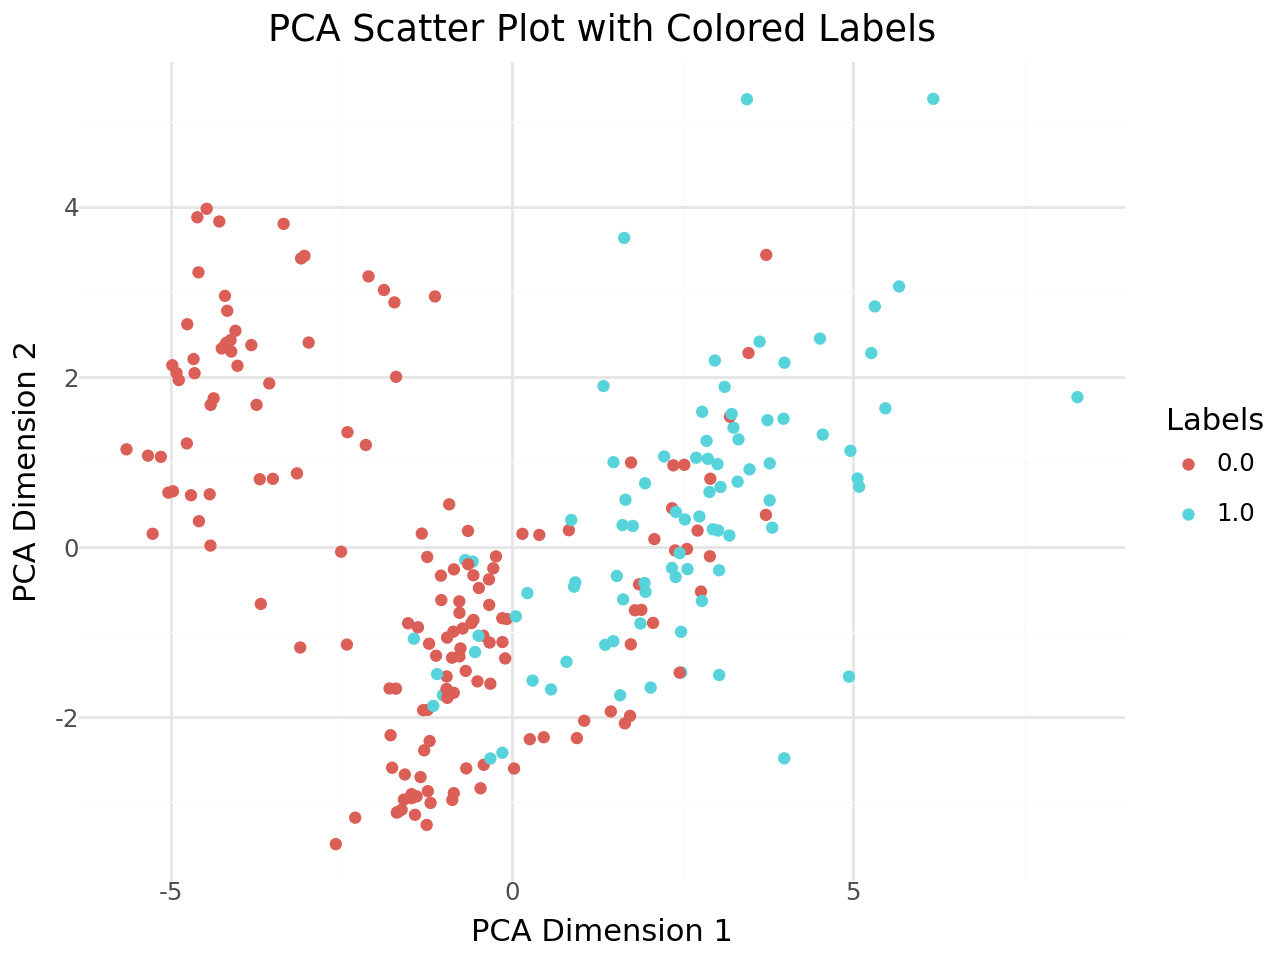

In [76]:
test_embeddings = model.transform(test_dataset)
flexynesis.plot_dim_reduced(test_embeddings, test_dataset.ann['STUDY'])

3.1 Exercises

Exercise 1:
Look up what Harrell's C-index means and write down a simple description of what it measures.

- Harrell’s C-index (also known as the concordance index) introduced in Harrell et al. 1982, is a goodness of fit measure for models which produce risk scores. It is commonly used to evaluate risk models in survival analysis, where data may be censored.

- It is the most common approach to evaluate the predictive performance of the ensemble is the calculation of the C statistic for survival data. A value of C = 05 corresponds to a non-informative prediction rule whereas C = 1 corresponds to perfect association, implying that Harrells C is an easy-to-interpret coe cient that accounts for the whole range of the observed survival times. 

Exercise 2:
Now, you build a model using hyperparameter tuning (run at least 10 HPO steps) to predict the survival outcomes of patients. Evaluate the final model on test dataset, which computes the "C-index".

Feel free to cheat from the tutorial available here: https://github.com/BIMSBbioinfo/flexynesis/blob/main/examples/tutorials/survival_subtypes_LGG_GBM.ipynb See how "OS_STATUS" and "OS_MONTHS" were used.

In [79]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 10

In [80]:
# Define a tuner
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = [], 
                                        n_iter=HPO_ITER, 
                                        plot_losses=True, 
                                        early_stop_patience=10)

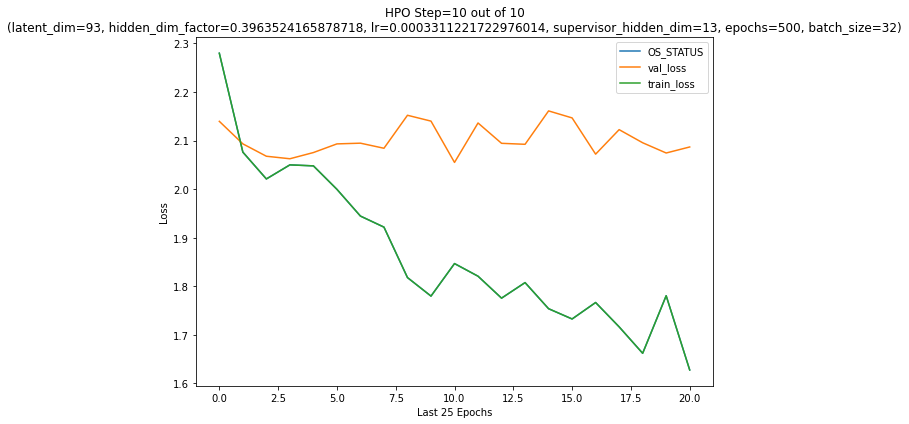

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │    2.0869463213213213     │
│         val_loss          │    2.0869463213213213     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 10/10 [00:59<00:00,  5.91s/it, Iteration=10, Best Loss=1.78]

[INFO] current best val loss: 1.7834834834834834; best params: {'latent_dim': 93, 'hidden_dim_factor': 0.41769859488495203, 'lr': 0.0060990527669989485, 'supervisor_hidden_dim': 31, 'epochs': 500, 'batch_size': 32} since 6 hpo iterations


{'latent_dim': 93,
 'hidden_dim_factor': 0.41769859488495203,
 'lr': 0.0060990527669989485,
 'supervisor_hidden_dim': 31,
 'epochs': 23,
 'batch_size': 32}

In [83]:
#Perform Training
model, best_params = tuner.perform_tuning()
best_params

In [84]:
# Evaluating the model and visualising the results
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,OS_STATUS,numerical,cindex,0.721798


Exercise 3:

Again build a model using hyperparameter tuning to predict survival outcomes (as in Exercise 1), however, this time use additional clinical variables as targets.

flexynesis.HyperparameterTuning(train_dataset, 
                                model_class = flexynesis.DirectPred, 
                                config_name = "DirectPred",
                                surv_event_var="OS_STATUS",
                                surv_time_var="OS_MONTHS",
                                target_variables = [], => What other variables can you use here? Try "AGE" and/or "HISTOLOGICAL_DIAGNOSIS" and see the model performance 
                                ...
                                
See if you can get a better C-index using additional target variables.

In [90]:
flexynesis.HyperparameterTuning(train_dataset, 
                                model_class = flexynesis.DirectPred, 
                                config_name = "DirectPred",
                                surv_event_var="OS_STATUS",
                                surv_time_var="OS_MONTHS",
                                target_variables = ["AGE", "HISTOLOGICAL_DIAGNOSIS"])

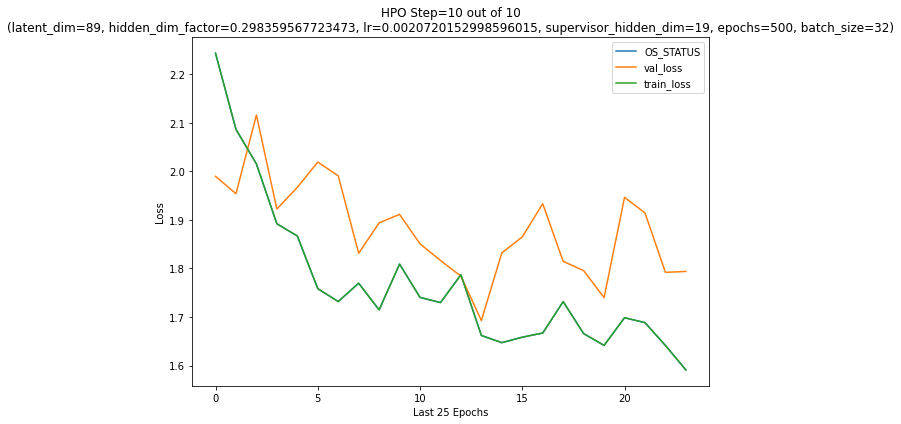

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │     1.79383645008645      │
│         val_loss          │     1.79383645008645      │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 10/10 [01:20<00:00,  8.10s/it, Iteration=10, Best Loss=1.79]

[INFO] current best val loss: 1.79383645008645; best params: {'latent_dim': 89, 'hidden_dim_factor': 0.298359567723473, 'lr': 0.0020720152998596015, 'supervisor_hidden_dim': 19, 'epochs': 500, 'batch_size': 32} since 0 hpo iterations


{'latent_dim': 89,
 'hidden_dim_factor': 0.298359567723473,
 'lr': 0.0020720152998596015,
 'supervisor_hidden_dim': 19,
 'epochs': 23,
 'batch_size': 32}

In [91]:
#Perform Training
model, best_params = tuner.perform_tuning()
best_params

In [92]:
# Evaluating the model and visualising the results
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,OS_STATUS,numerical,cindex,0.693822


3.2 Survival-risk subtypes
Use the best model from the above exercises to inspect sample embeddings categorized by survival risk scores.

Let's group the samples by predicted survival risk scores into 2 groups and visualize the sample embeddings colored by risk subtypes.

Notice: You can use the code-below to get survival risk groups, however, notice that you must have built a model with "OS_STATUS" already.

In [93]:
# get model outputs for survival variable 
outputs = model.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
# Define quantile thresholds
quantiles = np.quantile(risk_scores, [0.5])
# Assign groups based on quantiles
groups = np.digitize(risk_scores, quantiles)

In [94]:
# Extract sample embeddings 
E = model.transform(test_dataset)

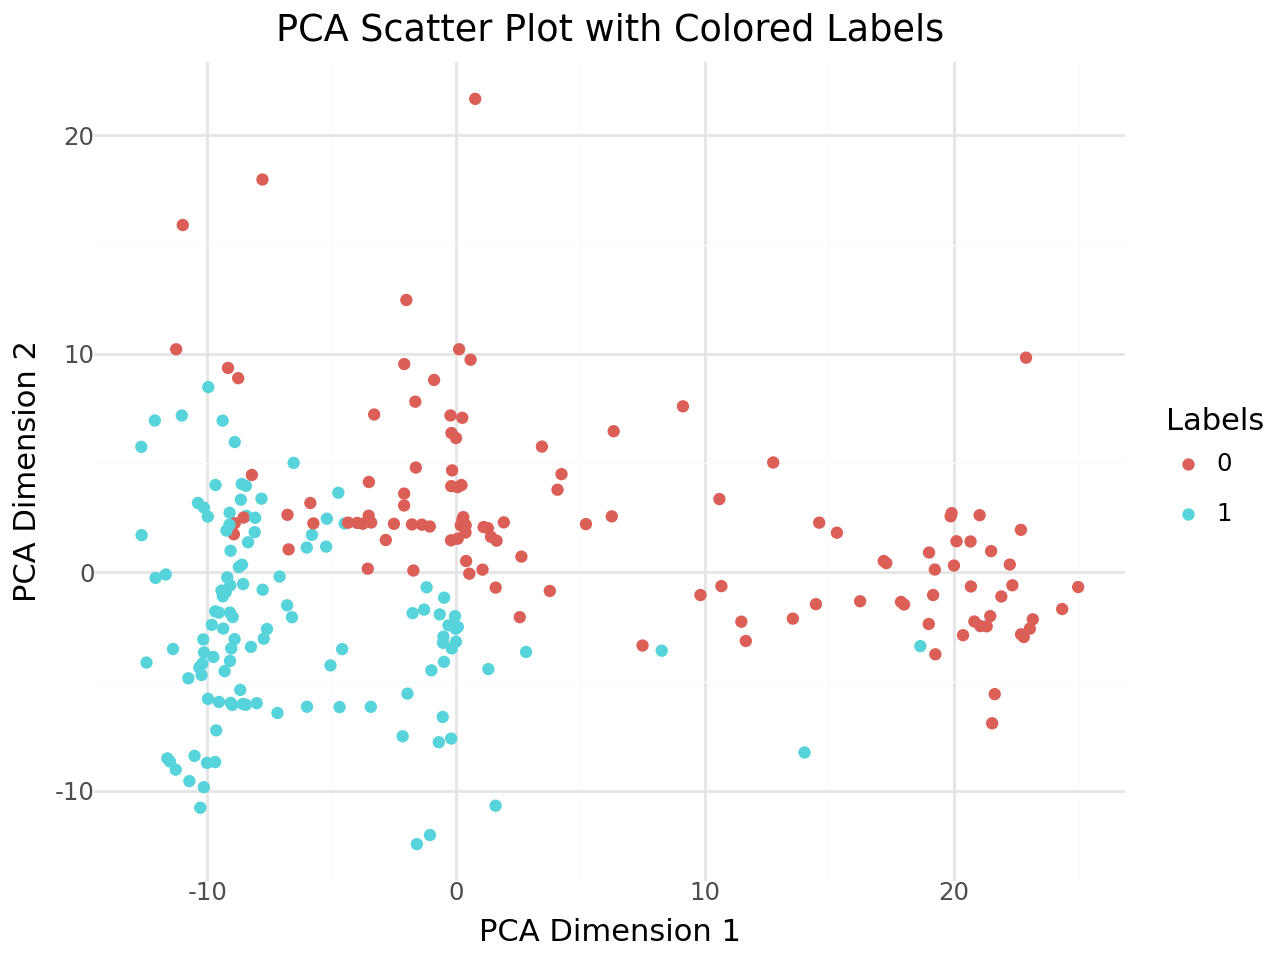

In [95]:
flexynesis.plot_dim_reduced(E, groups)

In [96]:
# remove samples with NA values first 
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

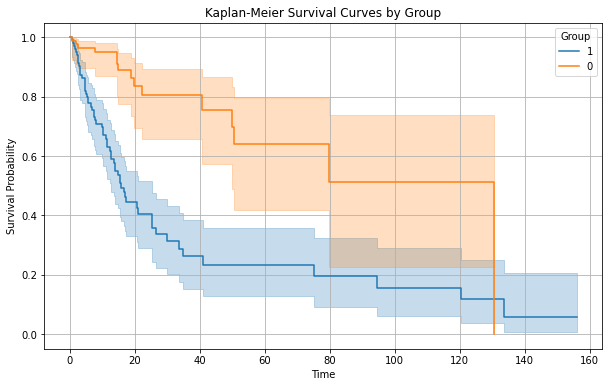

In [97]:
flexynesis.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 

### Finding survival-associated markers
We can also compute feature importance scores for prediction of overall survival.

In [99]:
model.compute_feature_importance(train_dataset, 'OS_STATUS')

In [100]:
# get top 10 features 
flexynesis.get_important_features(model, var = 'OS_STATUS', top=10)

,target_variable,target_class,target_class_label,layer,name,importance
0,OS_STATUS,0,,mut,IDH1,0.821111
1,OS_STATUS,0,,mut,TP53,0.250649
2,OS_STATUS,0,,mut,IDH2,0.099870
3,OS_STATUS,0,,mut,ATRX,0.096401
4,OS_STATUS,0,,mut,MUC16,0.052030
5,OS_STATUS,0,,mut,CIC,0.036496
6,OS_STATUS,0,,mut,NTF3,0.026293
7,OS_STATUS,0,,mut,EGFR,0.025760
8,OS_STATUS,0,,mut,C14orf39,0.024774
9,OS_STATUS,0,,mut,OPRK1,0.024336


### Comparing top markers with clinical covariates

Let's build a linear Cox-PH model including the top 5 markers and other clinical variables such as histological diagnosis, disease type (STUDY), age, and sex.

In [101]:
# define a data.frame with clinical covariates and top markers along with survival endpoints 
vars = ['AGE', 'SEX', 'HISTOLOGICAL_DIAGNOSIS', 'STUDY', 'OS_MONTHS', 'OS_STATUS']
# read clinical variables 
df_clin = pd.concat(
    [pd.DataFrame({x: train_dataset.ann[x] for x in vars}, index=train_dataset.samples),
     pd.DataFrame({x: test_dataset.ann[x] for x in vars}, index=test_dataset.samples)], 
    axis = 0)
# get top 5 survival markers and extract the input data for these markers for both training and test data
imp = flexynesis.get_important_features(model, var = 'OS_STATUS', top=5) 
df_imp = pd.concat([train_dataset.get_feature_subset(imp), test_dataset.get_feature_subset(imp)], axis=0)  

# combine markers with clinical variables
df = pd.concat([df_imp, df_clin], axis = 1)
# remove samples without survival endpoints
df = df[df['OS_STATUS'].notna()]
df

,mut_IDH1,mut_TP53,mut_IDH2,mut_ATRX,mut_MUC16,AGE,SEX,HISTOLOGICAL_DIAGNOSIS,STUDY,OS_MONTHS,OS_STATUS
TCGA-S9-A6WD,0.982173,-0.809174,-0.148522,-0.585658,-0.363845,58.0,1.0,3.0,0.0,62.3,0.0
TCGA-14-0871,-1.018150,1.235829,-0.148522,-0.585658,-0.363845,74.0,0.0,1.0,1.0,28.9,1.0
TCGA-DH-A66D,0.982173,1.235829,-0.148522,1.707482,-0.363845,43.0,0.0,0.0,0.0,15.7,0.0
TCGA-HT-A614,0.982173,1.235829,-0.148522,1.707482,-0.363845,47.0,1.0,2.0,0.0,2.7,0.0
TCGA-HW-7491,-1.018150,-0.809174,6.733003,-0.585658,-0.363845,35.0,1.0,3.0,0.0,40.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-HW-8321,0.982173,1.235829,-0.148522,-0.585658,-0.363845,31.0,1.0,0.0,0.0,19.6,0.0
TCGA-HT-7687,0.982173,-0.809174,-0.148522,-0.585658,-0.363845,74.0,1.0,3.0,0.0,0.1,0.0
TCGA-TM-A7CA,0.982173,1.235829,-0.148522,1.707482,-0.363845,44.0,1.0,0.0,0.0,22.6,0.0
TCGA-14-1450,-1.018150,-0.809174,-0.148522,-0.585658,-0.363845,57.0,0.0,1.0,1.0,58.7,0.0


In [102]:
# build a cox model
coxm = flexynesis.build_cox_model(df, 'OS_MONTHS', 'OS_STATUS')

No low variance features were removed based on event conditioning.


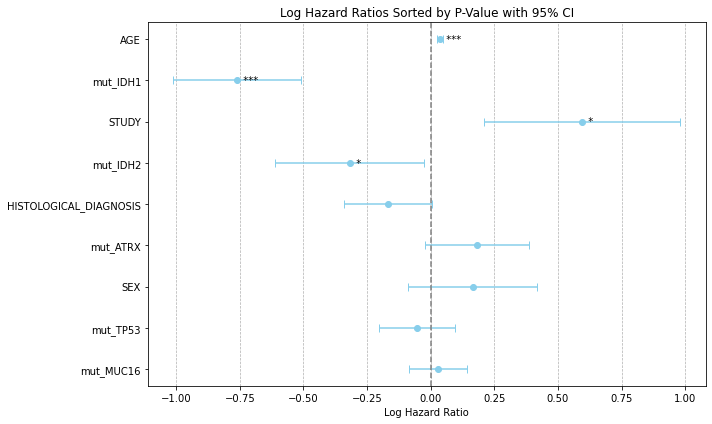

In [103]:
# visualize log-hazard ratios sorted by p-values
flexynesis.plot_hazard_ratios(coxm)

3.3 Final Exercise

Inspect the top 10 markers from section 3.2 and see if they have been characterized in the literature as important markers for Glioma disease progression.

They are important markers for Glioma disease progression.